In [1]:
from eigen_rootfinding.utils import condeigs
from eigen_rootfinding.polyroots import solve
from eigen_rootfinding.Multiplication import *
import eigen_rootfinding as er
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
from tests.devastating_example_test_scripts import *
from tests.conditioning_ratios import *
from scipy.stats import linregress
from scipy.spatial.distance import pdist
%load_ext autoreload
%autoreload 2

# Arbitrary precision tests are very slow, so I'm just running the high multiplicity root tests on this branch. All the code here is loading in data from tests run on the server

# Generate Random Systems with known roots

Goal: Find $n$ hyperellipses that have common roots at  chosen points $\mathbf {r_1,\ldots,r_n}$. 

Let's just take this one hyperellipse at a time.

Pick a chosen center $\mathbf c$ of the hyperellipse.

Then the equation for the hyperellipse is

$$f(\mathbf x) = \sum_{j=1}^n \frac{(x_j - c_j)^2}{a_{j}^2} - 1$$

and it has a root at $\mathbf r_i$ iff

$$\sum_{j=1}^n \frac{(r_{ij} - c_j)^2}{a_{j}^2} = 1$$

Good news! This is just a linear system in $1/a_i^2$!

$$\begin{bmatrix}
(r_{11} - c_1)^2       &   (r_{11} - c_2)^2       & \dots     &   (r_{1n} - c_n)^2       \\
(r_{21} - c_1)^2       &   (r_{21} - c_2)^2       & \dots     &   (r_{2n} - c_n)^2       \\
\vdots  &  \vdots   &   \vdots  &   \vdots  \\   
(r_{n1} - c_1)^2       &   (r_{n1} - c_2)^2       & \dots     &   (r_{nn} - c_n)^2       \\
\end{bmatrix}
\begin{bmatrix}
1/a_1^2    \\
1/a_2^2     \\
\vdots  \\
1/a_n^2     \\
\end{bmatrix}=
\mathbb 1$$

If you get a solution that has some negative outputs for $1/a_i^2$, then you've got some sort of cross between a hyperellipse and a hyperhyperbola.

For convenience, we're just going to use $1/a_i^2$ for our coefficients and not actually convert to $a_i$. In the code, I've denoted the $\mathbf a$ vector as `scalar`.

If we repeat this process $n$ times, we end up with $n$ hyper-conics that have common roots at $\mathbf {r_1,\ldots,r_n}$.

In [2]:
np.random.seed(0)
dim = 2
roots = np.random.randn(dim,dim)
centers = np.random.randn(dim,dim)
print('Chosen Roots:',*roots)
print('Chosen Centers:',*centers)

Chosen Roots: [1.76405235 0.40015721] [0.97873798 2.2408932 ]
Chosen Centers: [ 1.86755799 -0.97727788] [ 0.95008842 -0.15135721]


In [3]:
mp.matrix([[coord for coord in root] for root in roots])

matrix(
[['1.76405234596766', '0.400157208367223'],
 ['0.978737984105739', '2.24089319920146']])

In [4]:
scalars = [get_scalar(c,roots) for c in centers]
print('Scalars:',*scalars)

Scalars: [-6.09487717  0.56147239] [1.42922176 0.17453276]


In [5]:
polys = [get_MultiPower(c,roots) for c in centers]
print('Coefficients of Polynomials:',*[p.coeff for p in polys],sep='\n')

Coefficients of Polynomials:
[[-21.72130051   1.0974291    0.56147239]
 [ 22.76507313   0.           0.        ]
 [ -6.09487717   0.           0.        ]]
[[ 0.29411112  0.05283358  0.17453276]
 [-2.71577408  0.          0.        ]
 [ 1.42922176  0.          0.        ]]


In [6]:
roots, polys = gen_almost_high_multiplicity_root(3,3,.0001,123,True)

Centers:
[[-1.0856306   0.99734545  0.2829785 ]
 [-1.50629471 -0.57860025  1.65143654]
 [-2.42667924 -0.42891263  1.26593626]]
Primary Root:
[[-0.8667404  -0.67888615 -0.09470897]]
Perturbation Directions:
[[ 1.49138963e-04 -6.38901997e-05 -4.43981960e-05]
 [-4.34351276e-05  2.20593008e-04  2.18678609e-04]]
2 Nearby Root(s):
[[-0.86659126 -0.67895004 -0.09475337]
 [-0.86678384 -0.67866556 -0.09449029]]
0 Other Fixed Root(s):
[]
All Fixed Roots:
[[-0.8667404  -0.67888615 -0.09470897]
 [-0.86659126 -0.67895004 -0.09475337]
 [-0.86678384 -0.67866556 -0.09449029]]


In [7]:
np.array(mp.chop(er.solve(polys)).tolist(),dtype='complex')

array([[-1.13690694-4.11421669e+00j, -0.63221006+7.14549368e-01j,
         2.30067894-1.57407180e-01j],
       [-1.13690694+4.11421669e+00j, -0.63221006-7.14549368e-01j,
         2.30067894+1.57407180e-01j],
       [ 1.36339452-4.11297767e+00j, -0.29106916-7.14334157e-01j,
         2.29995759+1.29824794e+00j],
       [ 1.36339452+4.11297767e+00j, -0.29106916+7.14334157e-01j,
         2.29995759-1.29824794e+00j],
       [-0.86659132+2.25322047e-09j, -0.67895004+7.60163526e-10j,
        -0.09475338-5.62869789e-10j],
       [-0.86674032-3.65918917e-09j, -0.67888616-1.23200303e-09j,
        -0.09470895+9.14927537e-10j],
       [-0.86675198-8.45736612e-09j, -0.67864692-3.09527929e-09j,
        -0.09446682+2.19071758e-09j],
       [-0.86678408+9.86333482e-09j, -0.67866553+3.56711826e-09j,
        -0.09449036-2.54277534e-09j]])

# Generate Random Systems that Almost have Multiple Roots

### roots of multiplicity dim

In [8]:
alphas = np.array([1.00000000e-06, 1.26485522e-06, 1.59985872e-06,
         2.02358965e-06, 2.55954792e-06, 3.23745754e-06,
         4.09491506e-06, 5.17947468e-06, 6.55128557e-06,
         8.28642773e-06, 1.04811313e-05, 1.32571137e-05,
         1.67683294e-05, 2.12095089e-05, 2.68269580e-05,
         3.39322177e-05, 4.29193426e-05, 5.42867544e-05,
         6.86648845e-05, 8.68511374e-05, 1.09854114e-04,
         1.38949549e-04, 1.75751062e-04, 2.22299648e-04,
         2.81176870e-04, 3.55648031e-04, 4.49843267e-04,
         5.68986603e-04, 7.19685673e-04, 9.10298178e-04,
         1.15139540e-03, 1.45634848e-03, 1.84206997e-03,
         2.32995181e-03, 2.94705170e-03, 3.72759372e-03,
         4.71486636e-03, 5.96362332e-03, 7.54312006e-03,
         9.54095476e-03, 1.20679264e-02, 1.52641797e-02,
         1.93069773e-02, 2.44205309e-02, 3.08884360e-02,
         3.90693994e-02, 4.94171336e-02, 6.25055193e-02,
         7.90604321e-02, 1.00000000e-01, 1e-5,
         1e-4, 1e-3, 1e-2])
alphasrt = np.argsort(alphas)

In [9]:
folder = 'tests/conditioning_ratios/nearby_roots/mult/'
condratios = []
eigenconds = []
rootconds = []
testsperdim = 100
digitsprecision = 100
for alpha in alphas:
    alphastr = str(alpha).replace('.','_')
    filename = 'alpha'+alphastr+f'_{testsperdim}testsperdim_{digitsprecision}digitsprecision'
    fileend = '.npy'
    condratios.append(np.load(folder+filename+fileend,allow_pickle=True).item())
    eigenconds.append(np.load(folder+filename+'_eigconds'+fileend,allow_pickle=True).item())
    rootconds.append(np.load(folder+filename+'_rootconds'+fileend,allow_pickle=True).item())
condratios,eigenconds,rootconds = np.array(condratios),np.array(eigenconds),np.array(rootconds)

In [10]:
def get_slope(dataset):
    dataset_log10 = [np.log10(dataset[d].flatten()) for d in dataset.keys()]
    dataset_log10_aspoints = np.array([[d,val] for i,d in enumerate(dataset.keys()) 
                                       for val in dataset_log10[i]])
    return linregress(dataset_log10_aspoints)[0]

In [11]:
change_dim_cratio_slopes_mult = np.array([get_slope(cratio) for cratio in condratios])
change_dim_eigc_slopes_mult = np.array([get_slope(eigc) for eigc in eigenconds])
change_dim_rootc_slopes_mult = np.array([get_slope(rootc) for rootc in rootconds])

In [12]:
np.save('tests/conditioning_ratios/alphas',alphas)
np.save('tests/conditioning_ratios/change_dim_mult_cratios',change_dim_cratio_slopes_mult)
np.save('tests/conditioning_ratios/change_dim_mult_eigc',change_dim_eigc_slopes_mult)
np.save('tests/conditioning_ratios/change_dim_mult_rootc',change_dim_rootc_slopes_mult)

In [13]:
alphas_for_plot = [1e-6,1e-4,1e-2]
alphas_for_plot_idx = np.array([np.where(alpha == alphas)[0].item() for alpha in alphas_for_plot])

$\alpha=10^{-6}$
Slope: 5.518879678133241 
Intercept: -10.937176289698735 
Exponential Growth Rate: 330277.02439183556

$\alpha=10^{-4}$
Slope: 3.525907358357858 
Intercept: -6.941187183584294 
Exponential Growth Rate: 3355.6600392313385

$\alpha=10^{-2}$
Slope: 1.571553159218953 
Intercept: -3.0516516238587035 
Exponential Growth Rate: 36.286632233934654

$\alpha=10^{-6}$
Slope: 5.518879678133241 
Intercept: -10.937176289698735 
Exponential Growth Rate: 330277.02439183556

$\alpha=10^{-4}$
Slope: 3.525907358357858 
Intercept: -6.941187183584294 
Exponential Growth Rate: 3355.6600392313385

$\alpha=10^{-2}$
Slope: 1.571553159218953 
Intercept: -3.0516516238587035 
Exponential Growth Rate: 36.286632233934654



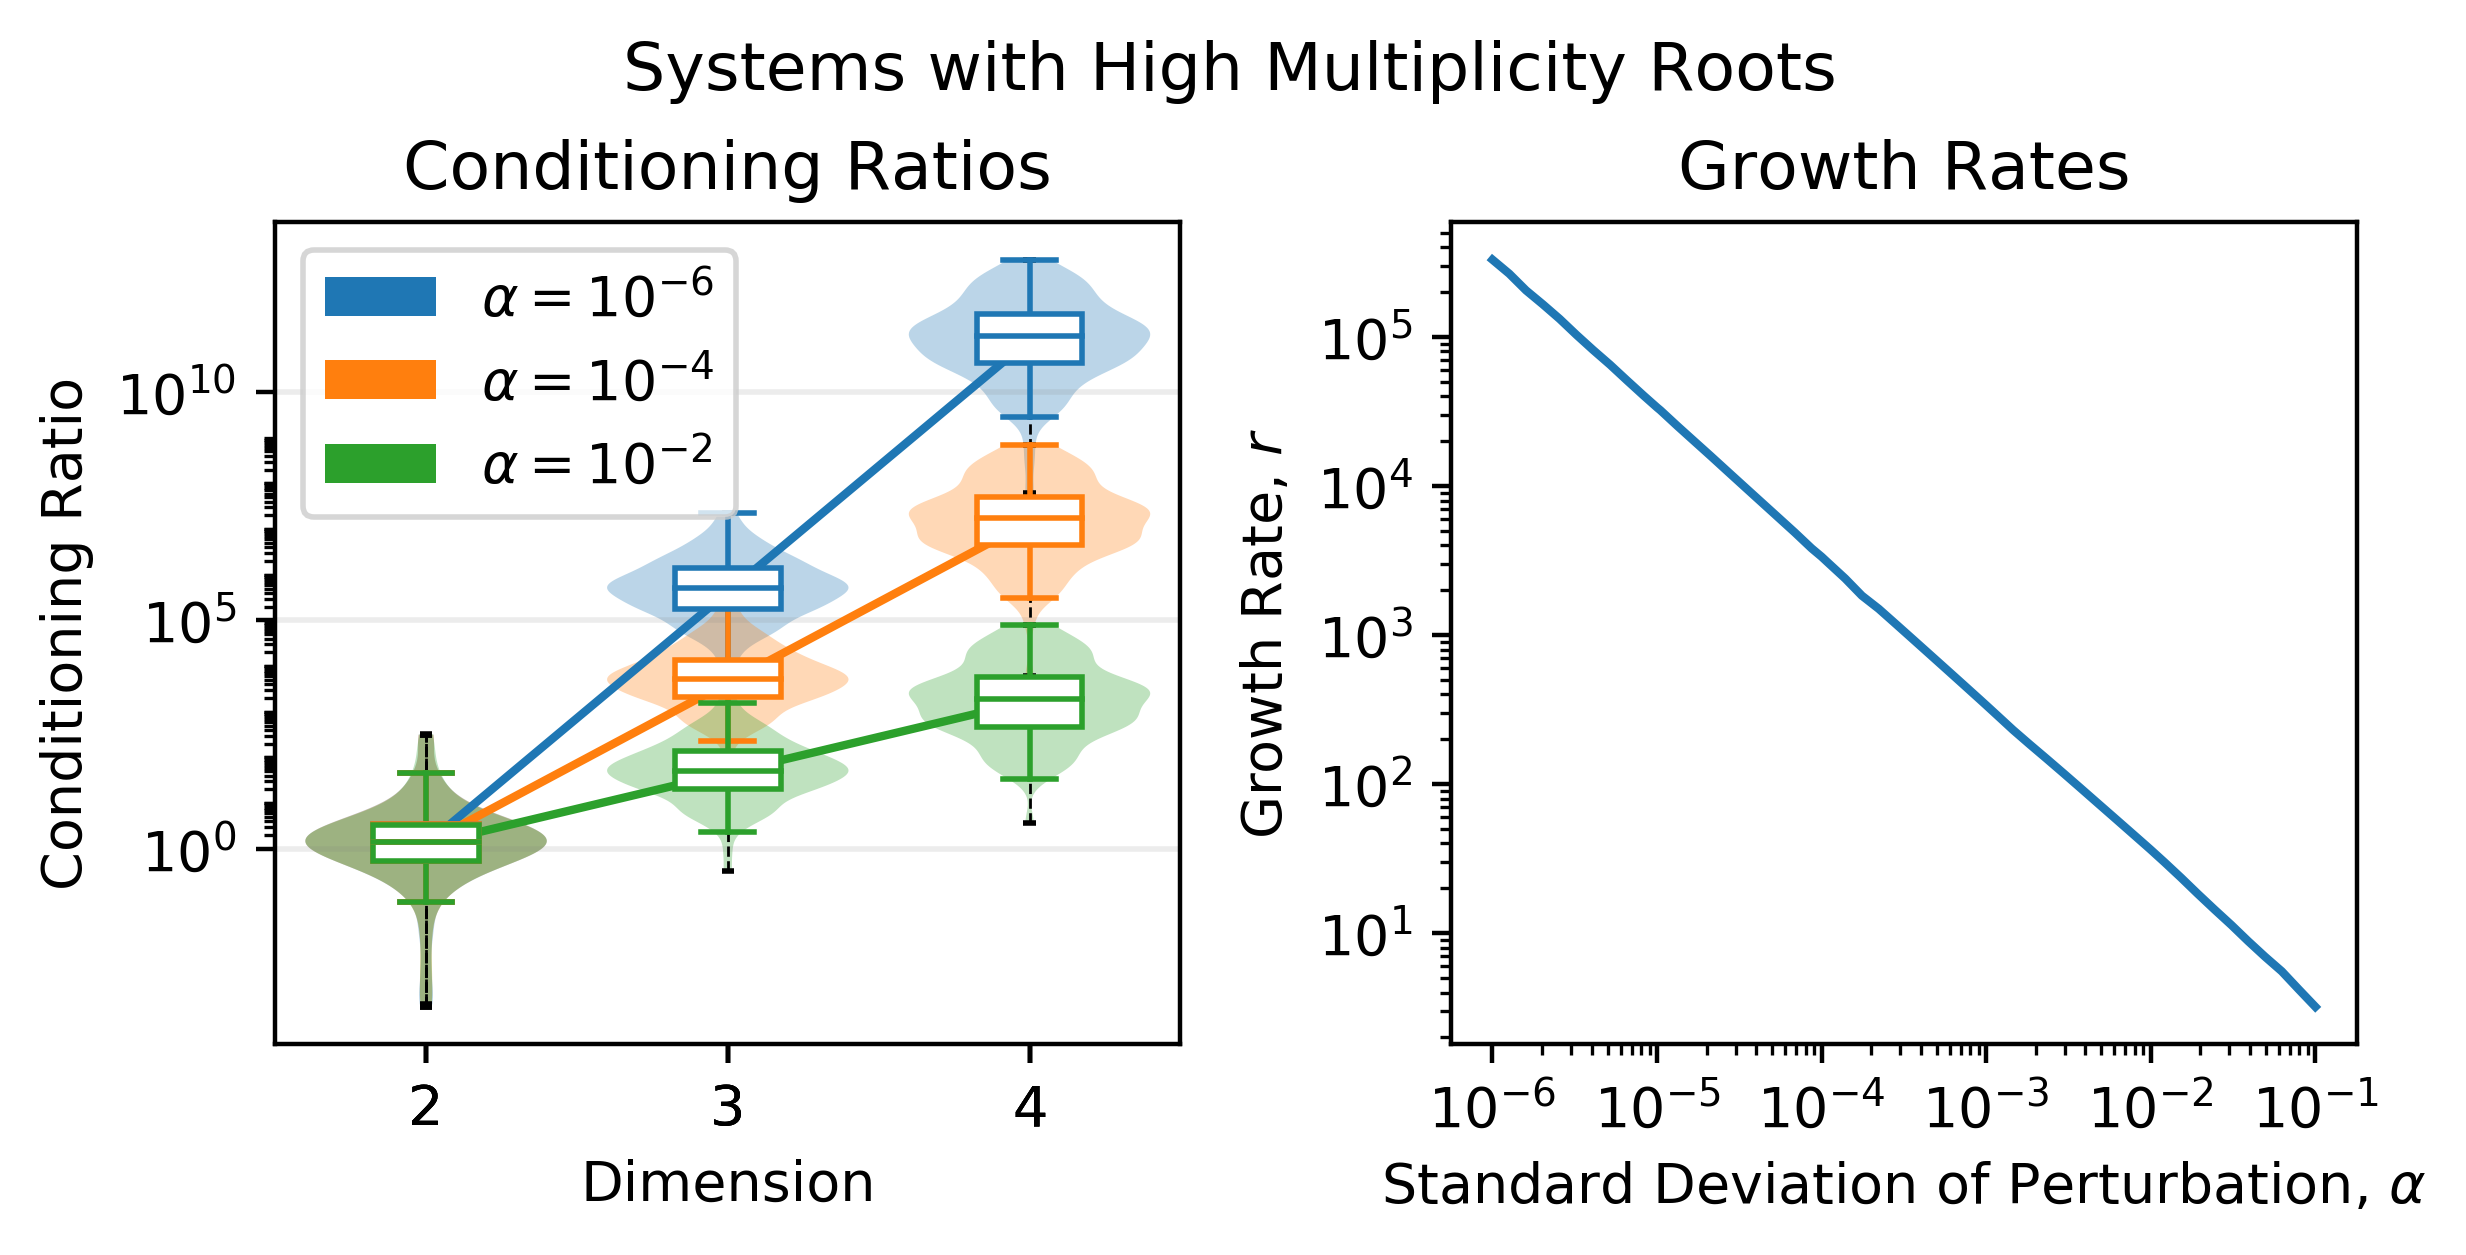

In [14]:
plot([condratios[alphas_for_plot_idx],condratios[alphas_for_plot_idx]],
     [[r'$\alpha=10^{-6}$',
      r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-2}$'],
      [r'$\alpha=10^{-6}$',
      r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-2}$']],
     figsize=(6.25,3.25), filename='high_multiplicities_with_growth_rates', 
     title=['Conditioning Ratios','Growth Rates',r'Systems with High Multiplicity Roots'],
     subplots=[1,2], 
     _2nd_plot=[alphas[alphasrt],10**np.array(change_dim_cratio_slopes_mult[alphasrt])-1],
     min_ylim=0,max_ylim=9,
    _2nd_plot_axis_labels=[r'Standard Deviation of Perturbation, $\alpha$','Growth Rate, $r$'])

### double, not multiple roots

I ran this set with a smaller sample size (20 tests per dimension per alpha value instead of 100), but that was because this test is very expensive to run-- it took overnight on a server with many cores to run the tests for the previous plot. Since I didn't see any exponential growth in dimension, I decided it wasn't worth the server time. 

In [15]:
alphas = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])

In [16]:
alphas_for_plot = [1e-6,1e-4,1e-2]
alphas_for_plot_idx = np.array([np.where(alpha == alphas)[0].item() for alpha in alphas_for_plot])

In [17]:
folder = 'tests/conditioning_ratios/nearby_roots/doub/'
condratios = []
eigenconds = []
rootconds = []
testsperdim = 20
digitsprecision = 100
for alpha in alphas:
    alphastr = str(alpha).replace('.','_')
    filename = 'alpha'+alphastr+f'_{testsperdim}testsperdim_{digitsprecision}digitsprecision'
    fileend = '.npy'
    condratios.append(np.load(folder+filename+fileend,allow_pickle=True).item())
    eigenconds.append(np.load(folder+filename+'_eigconds'+fileend,allow_pickle=True).item())
    rootconds.append(np.load(folder+filename+'_rootconds'+fileend,allow_pickle=True).item())
condratios,eigenconds,rootconds = np.array(condratios),np.array(eigenconds),np.array(rootconds)

In [18]:
change_dim_cratio_slopes_doub = np.array([get_slope(cratio) for cratio in condratios])
change_dim_eigc_slopes_doub = np.array([get_slope(eigc) for eigc in eigenconds])
change_dim_rootc_slopes_doub = np.array([get_slope(rootc) for rootc in rootconds])

In [19]:
np.save('tests/conditioning_ratios/alphas',alphas)
np.save('tests/conditioning_ratios/change_dim_doub_cratios',change_dim_cratio_slopes_doub)
np.save('tests/conditioning_ratios/change_dim_doub_eigc',change_dim_eigc_slopes_doub)
np.save('tests/conditioning_ratios/change_dim_doub_rootc',change_dim_rootc_slopes_doub)

$\alpha=10^{-6}$
Slope: -0.048569751415748076 
Intercept: 0.12346551586629509 
Exponential Growth Rate: -0.10580909432370866

$\alpha=10^{-4}$
Slope: -0.04562135874391966 
Intercept: 0.11311640367545775 
Exponential Growth Rate: -0.09971784619828827

$\alpha=10^{-2}$
Slope: -0.04536774715287747 
Intercept: 0.11380425778773595 
Exponential Growth Rate: -0.09919196185570167

$\alpha=10^{-6}$
Slope: -0.048569751415748076 
Intercept: 0.12346551586629509 
Exponential Growth Rate: -0.10580909432370866

$\alpha=10^{-4}$
Slope: -0.04562135874391966 
Intercept: 0.11311640367545775 
Exponential Growth Rate: -0.09971784619828827

$\alpha=10^{-2}$
Slope: -0.04536774715287747 
Intercept: 0.11380425778773595 
Exponential Growth Rate: -0.09919196185570167



/Users/SuzannaStephensonAdmin/Documents/Research/RootFindingResearch/eigen_rootfinding/tests/conditioning_ratios.py:535: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1].semilogy(_2nd_plot[0], _2nd_plot[1])


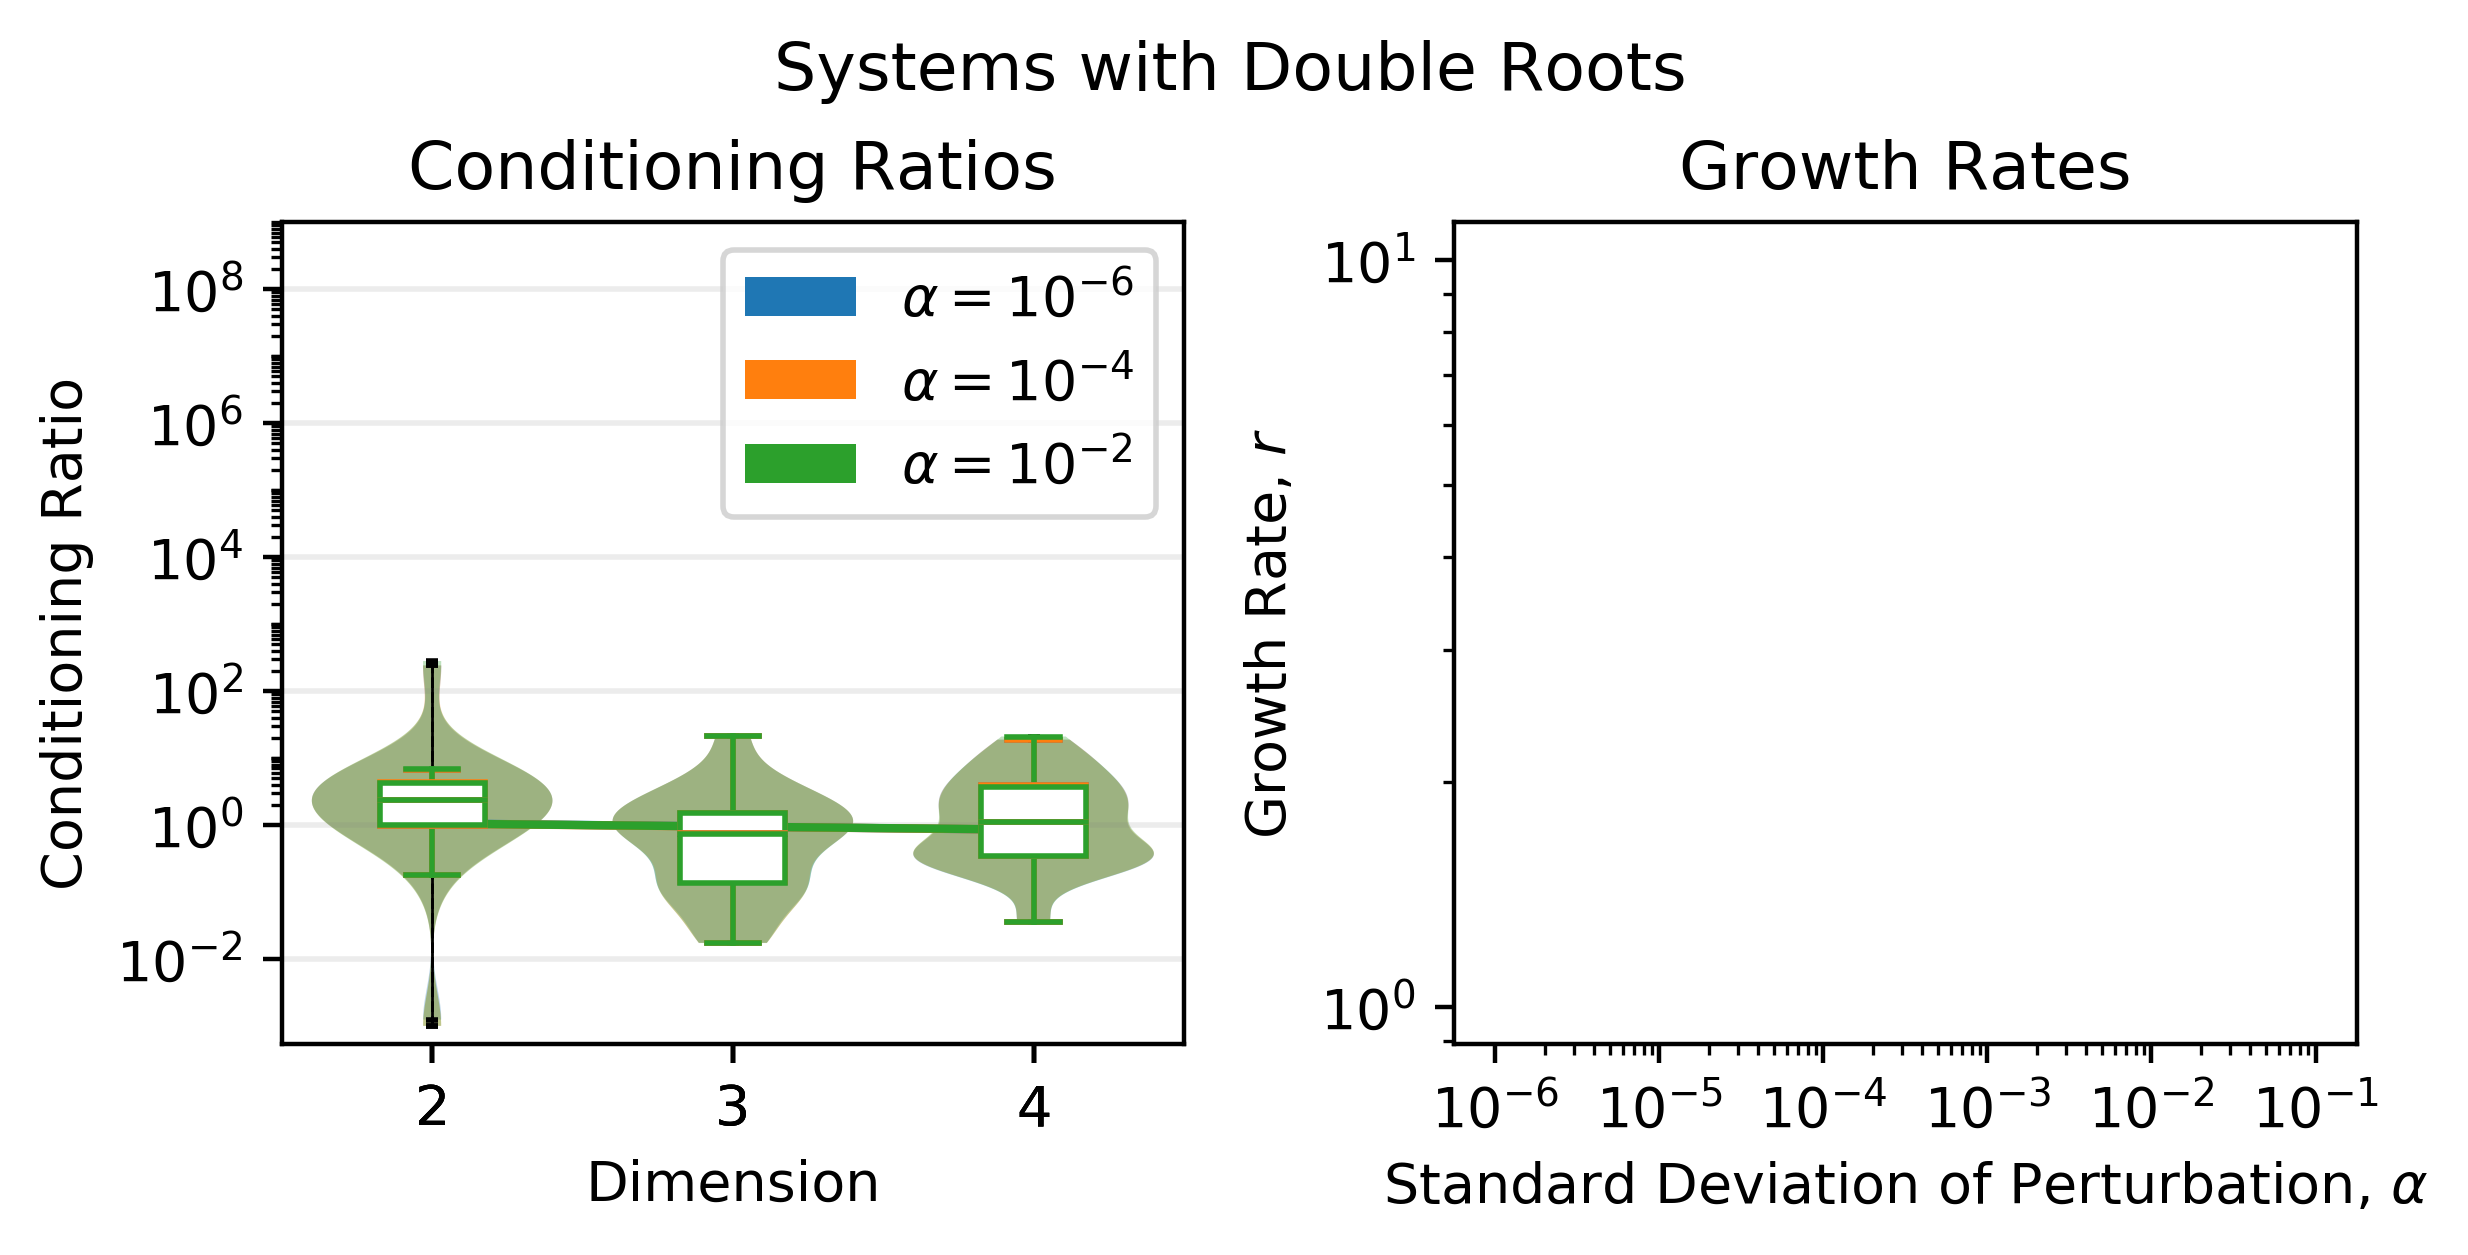

In [20]:
plot([condratios[alphas_for_plot_idx],condratios[alphas_for_plot_idx]],
     [[r'$\alpha=10^{-6}$',
      r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-2}$'],
      [r'$\alpha=10^{-6}$',
      r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-2}$']],
     figsize=(6.25,3.25), filename='double_roots_with_growth_rates', 
     title=['Conditioning Ratios','Growth Rates',r'Systems with Double Roots'],
     subplots=[1,2], 
     _2nd_plot=[alphas,10**np.array(change_dim_cratio_slopes_doub)-1],
     min_ylim=0,max_ylim=9,
    _2nd_plot_axis_labels=[r'Standard Deviation of Perturbation, $\alpha$','Growth Rate, $r$'])

$\alpha=10^{-6}$
Slope: 0.14598517993954338 
Intercept: 6.232685559297661 
Exponential Growth Rate: 0.39953956323949513

$\alpha=10^{-5}$
Slope: 0.14850443124312843 
Intercept: 5.223510821783568 
Exponential Growth Rate: 0.40768159130679926

$\alpha=10^{-4}$
Slope: 0.14848173735578518 
Intercept: 4.2235579390007665 
Exponential Growth Rate: 0.40760803538072343

$\alpha=10^{-3}$
Slope: 0.14817686999594176 
Intercept: 3.224292021612456 
Exponential Growth Rate: 0.4066202651551052

$\alpha=10^{-2}$
Slope: 0.1452629067600885 
Intercept: 2.23132521466238 
Exponential Growth Rate: 0.39721392976253456

$\alpha=10^{-1}$
Slope: 0.12935991343989955 
Intercept: 1.271395454089404 
Exponential Growth Rate: 0.3469761729788776

$\alpha=10^{-6}$
Slope: 0.23383563069264024 
Intercept: 5.982648901122132 
Exponential Growth Rate: 0.7133087414278618

$\alpha=10^{-5}$
Slope: 0.23355802086196742 
Intercept: 4.983352065169845 
Exponential Growth Rate: 0.7122139097290963

$\alpha=10^{-4}$
Slope: 0.23352236134

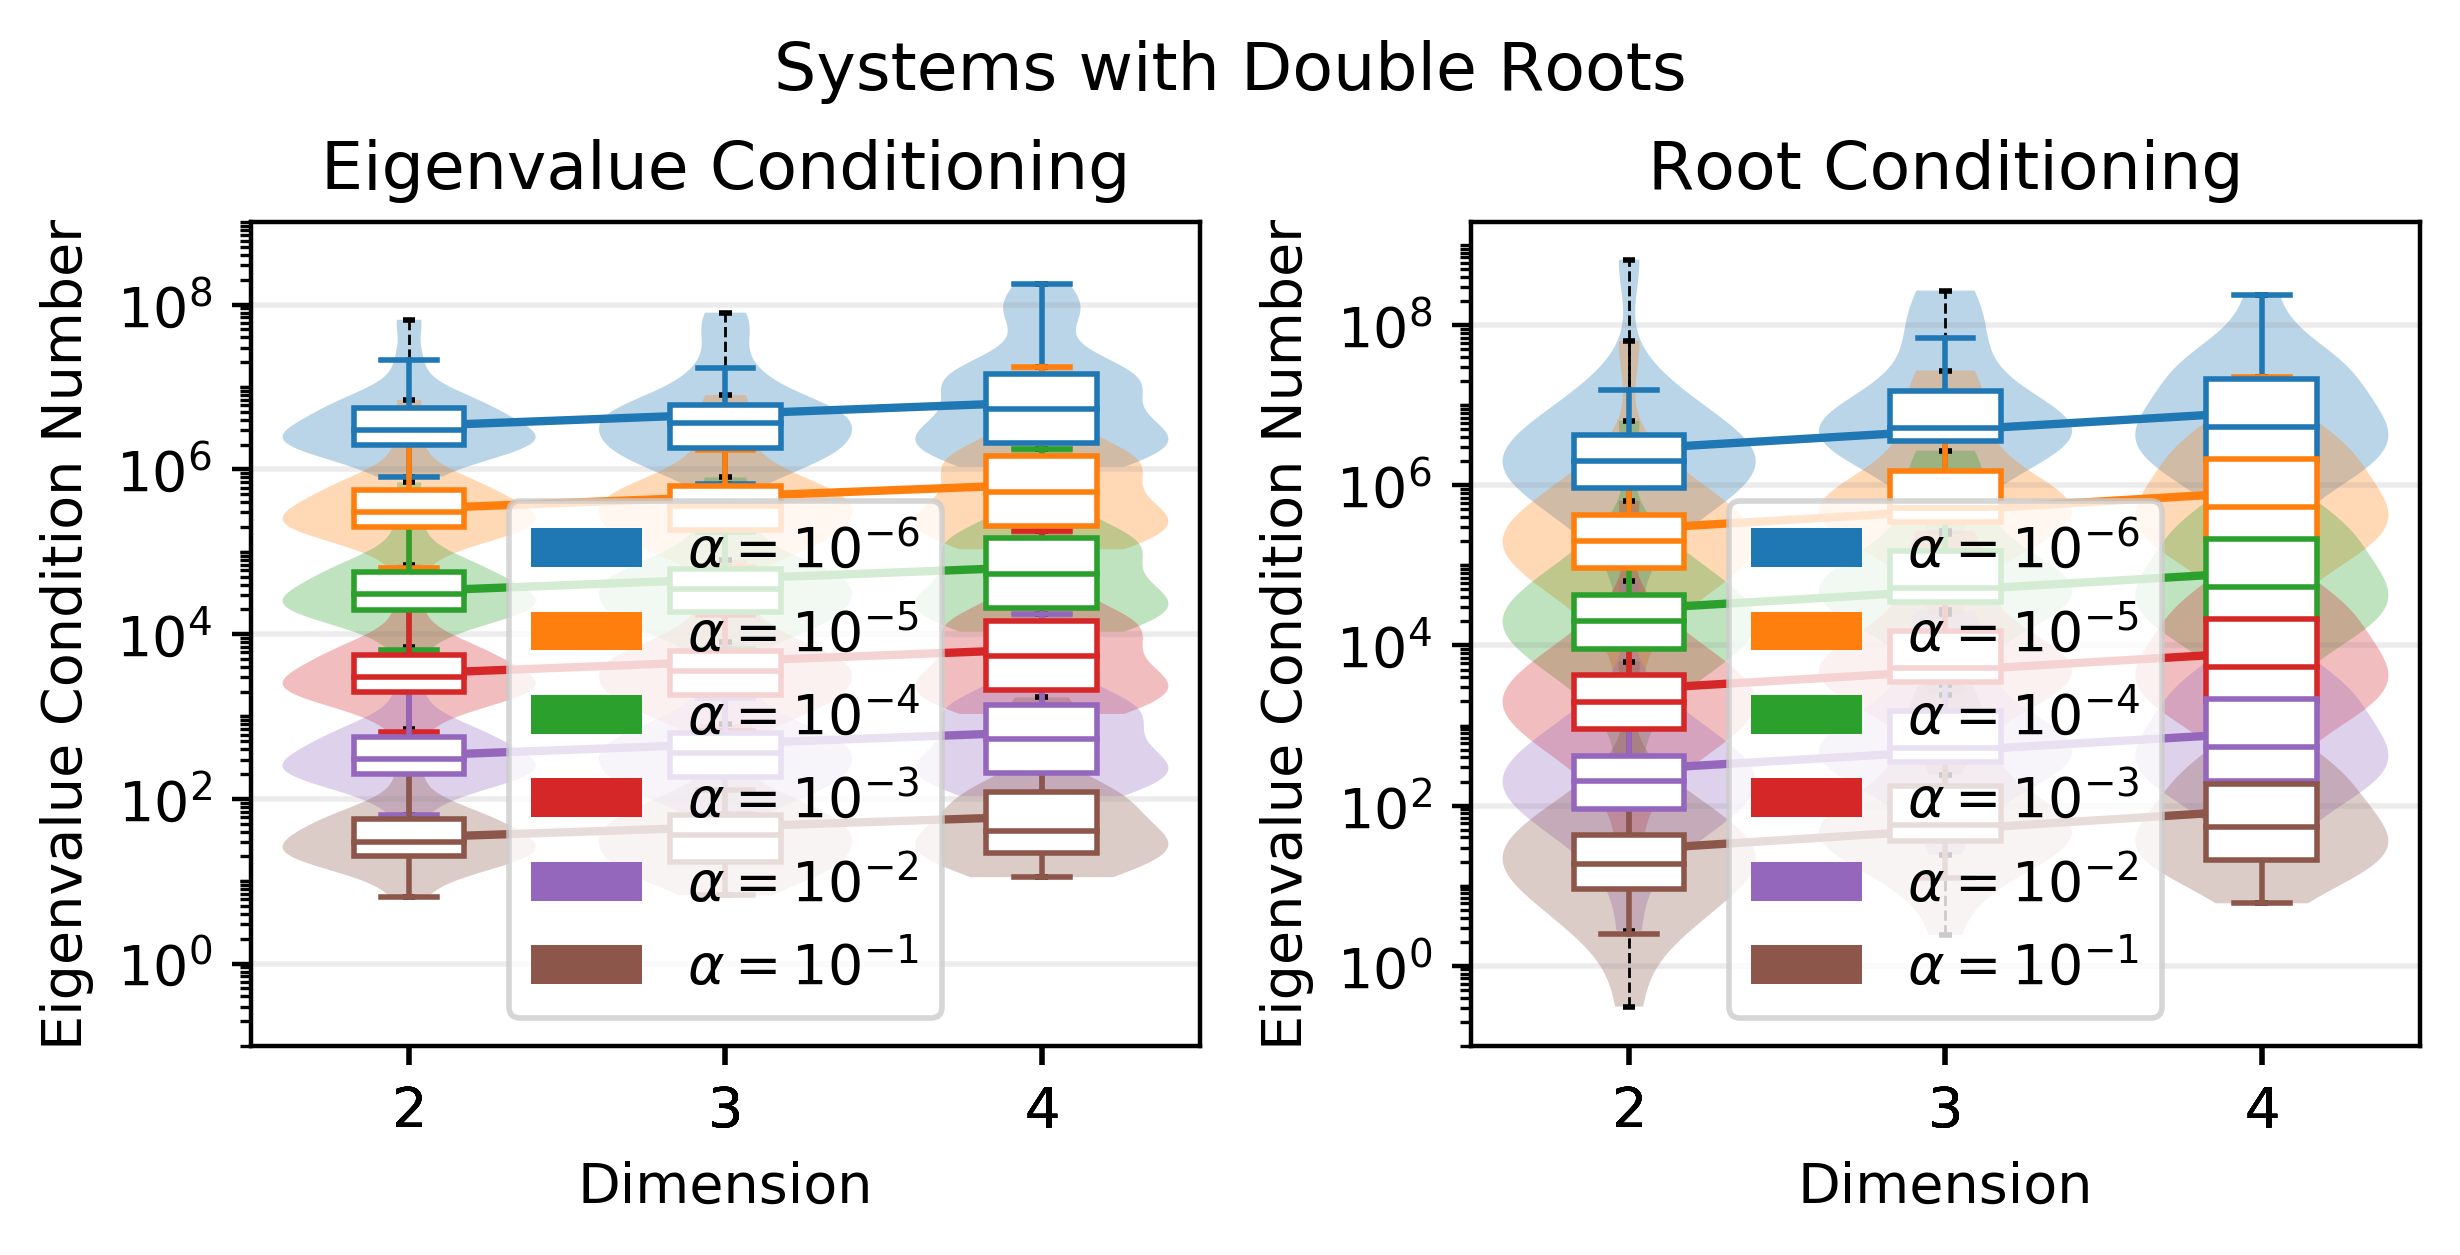

In [21]:
plot([eigenconds,rootconds],
     [[r'$\alpha=10^{-6}$',
       r'$\alpha=10^{-5}$',
       r'$\alpha=10^{-4}$',
       r'$\alpha=10^{-3}$',
       r'$\alpha=10^{-2}$',
       r'$\alpha=10^{-1}$'],
      [r'$\alpha=10^{-6}$',
       r'$\alpha=10^{-5}$',
       r'$\alpha=10^{-4}$',
       r'$\alpha=10^{-3}$',
       r'$\alpha=10^{-2}$',
       r'$\alpha=10^{-1}$']],
     figsize=(6.25,3.25), filename='double_roots_with_growth_rates', 
     title=['Eigenvalue Conditioning','Root Conditioning',r'Systems with Double Roots'],
     yaxislabel='Eigenvalue Condition Number',
     subplots=[1,2], 
     min_ylim=-1,max_ylim=9)

# What happens as you increase the multiplicity of a root in 4 dimensions (from 1 to 4)?

In [22]:
#load data and reformat it to plot
alphas = np.array([1.00000000e-06, 1.26485522e-06, 1.59985872e-06,
         2.02358965e-06, 2.55954792e-06, 3.23745754e-06,
         4.09491506e-06, 5.17947468e-06, 6.55128557e-06,
#          8.28642773e-06, 1.04811313e-05, 1.32571137e-05,
         1.67683294e-05, 2.12095089e-05, 2.68269580e-05,
         3.39322177e-05, 4.29193426e-05, 5.42867544e-05,
         6.86648845e-05, 8.68511374e-05, 1.09854114e-04,
         1.38949549e-04, 1.75751062e-04, 2.22299648e-04,
         2.81176870e-04, 3.55648031e-04, 4.49843267e-04,
         5.68986603e-04, 7.19685673e-04, 9.10298178e-04,
         1.15139540e-03, 1.45634848e-03, 1.84206997e-03,
         2.32995181e-03, 2.94705170e-03, 3.72759372e-03,
         4.71486636e-03, 5.96362332e-03, 7.54312006e-03,
         9.54095476e-03, 1.20679264e-02, 1.52641797e-02,
         1.93069773e-02, 2.44205309e-02, 3.08884360e-02,
         3.90693994e-02, 4.94171336e-02, 6.25055193e-02,
         7.90604321e-02, 1.00000000e-01, 1e-5,
         1e-4, 1e-3, 1e-2])
alphasrt = np.argsort(alphas)
path = 'tests/conditioning_ratios/nearby_roots/'
condratios = []
eigenconds = []
rootconds = []
testsperdim = 2
dim = 4
digitsprecision = 100
for alpha in alphas:
    condratiosdict = {}
    eigencondsdict = {}
    rootcondsdict = {}
    for multiplicity in range(2,5):
        folder = f'multiplicity{multiplicity}/'
        alphastr = str(alpha).replace('.','_')
        filename = 'alpha'+alphastr+f'final_{testsperdim}testsperdim_{digitsprecision}digitsprecision'
        fileend = '.npy'
        condratiosdict[multiplicity] = np.load(path+folder+filename+fileend,allow_pickle=True).item()[dim]
        eigencondsdict[multiplicity] = np.load(path+folder+filename+'_eigconds'+fileend,allow_pickle=True).item()[dim]
        rootcondsdict[multiplicity] = np.load(path+folder+filename+'_rootconds'+fileend,allow_pickle=True).item()[dim]
    condratios.append(condratiosdict)
    eigenconds.append(eigencondsdict)
    rootconds.append(rootcondsdict)
condratios = np.array(condratios)
eigenconds = np.array(eigenconds)
rootconds = np.array(rootconds)

In [23]:
dim4_cratio_slopes_mult = np.array([get_slope(cratio) for cratio in condratios])
dim4_eigc_slopes_mult = np.array([get_slope(eigc) for eigc in eigenconds])
dim4_rootc_slopes_mult = np.array([get_slope(rootc) for rootc in rootconds])

In [24]:
alphas_for_plot_idx = np.array([np.where(alphas==target)[0][0] for target in [1e-6,1e-4,1e-2]])
alphas_for_plot_idx

array([ 0, 48, 50])

$\alpha=10^{-6}$
Slope: 5.404723136493832 
Intercept: -4.077416193238195 
Exponential Growth Rate: 253934.33471480352

$\alpha=10^{-4}$
Slope: 3.4265699400899825 
Intercept: -2.1287530418686647 
Exponential Growth Rate: 2669.360775437058

$\alpha=10^{-2}$
Slope: 1.7608534654637746 
Intercept: -0.9243130365089263 
Exponential Growth Rate: 56.65718904627847

$\alpha=10^{-6}$
Slope: 0.4110771461459015 
Intercept: 5.356911265891485 
Exponential Growth Rate: 1.576778843917832

$\alpha=10^{-4}$
Slope: 0.41107481769977694 
Intercept: 3.356784860851635 
Exponential Growth Rate: 1.5767650286959518

$\alpha=10^{-2}$
Slope: 0.40844719663798595 
Intercept: 1.366704661597399 
Exponential Growth Rate: 1.5612218409600245



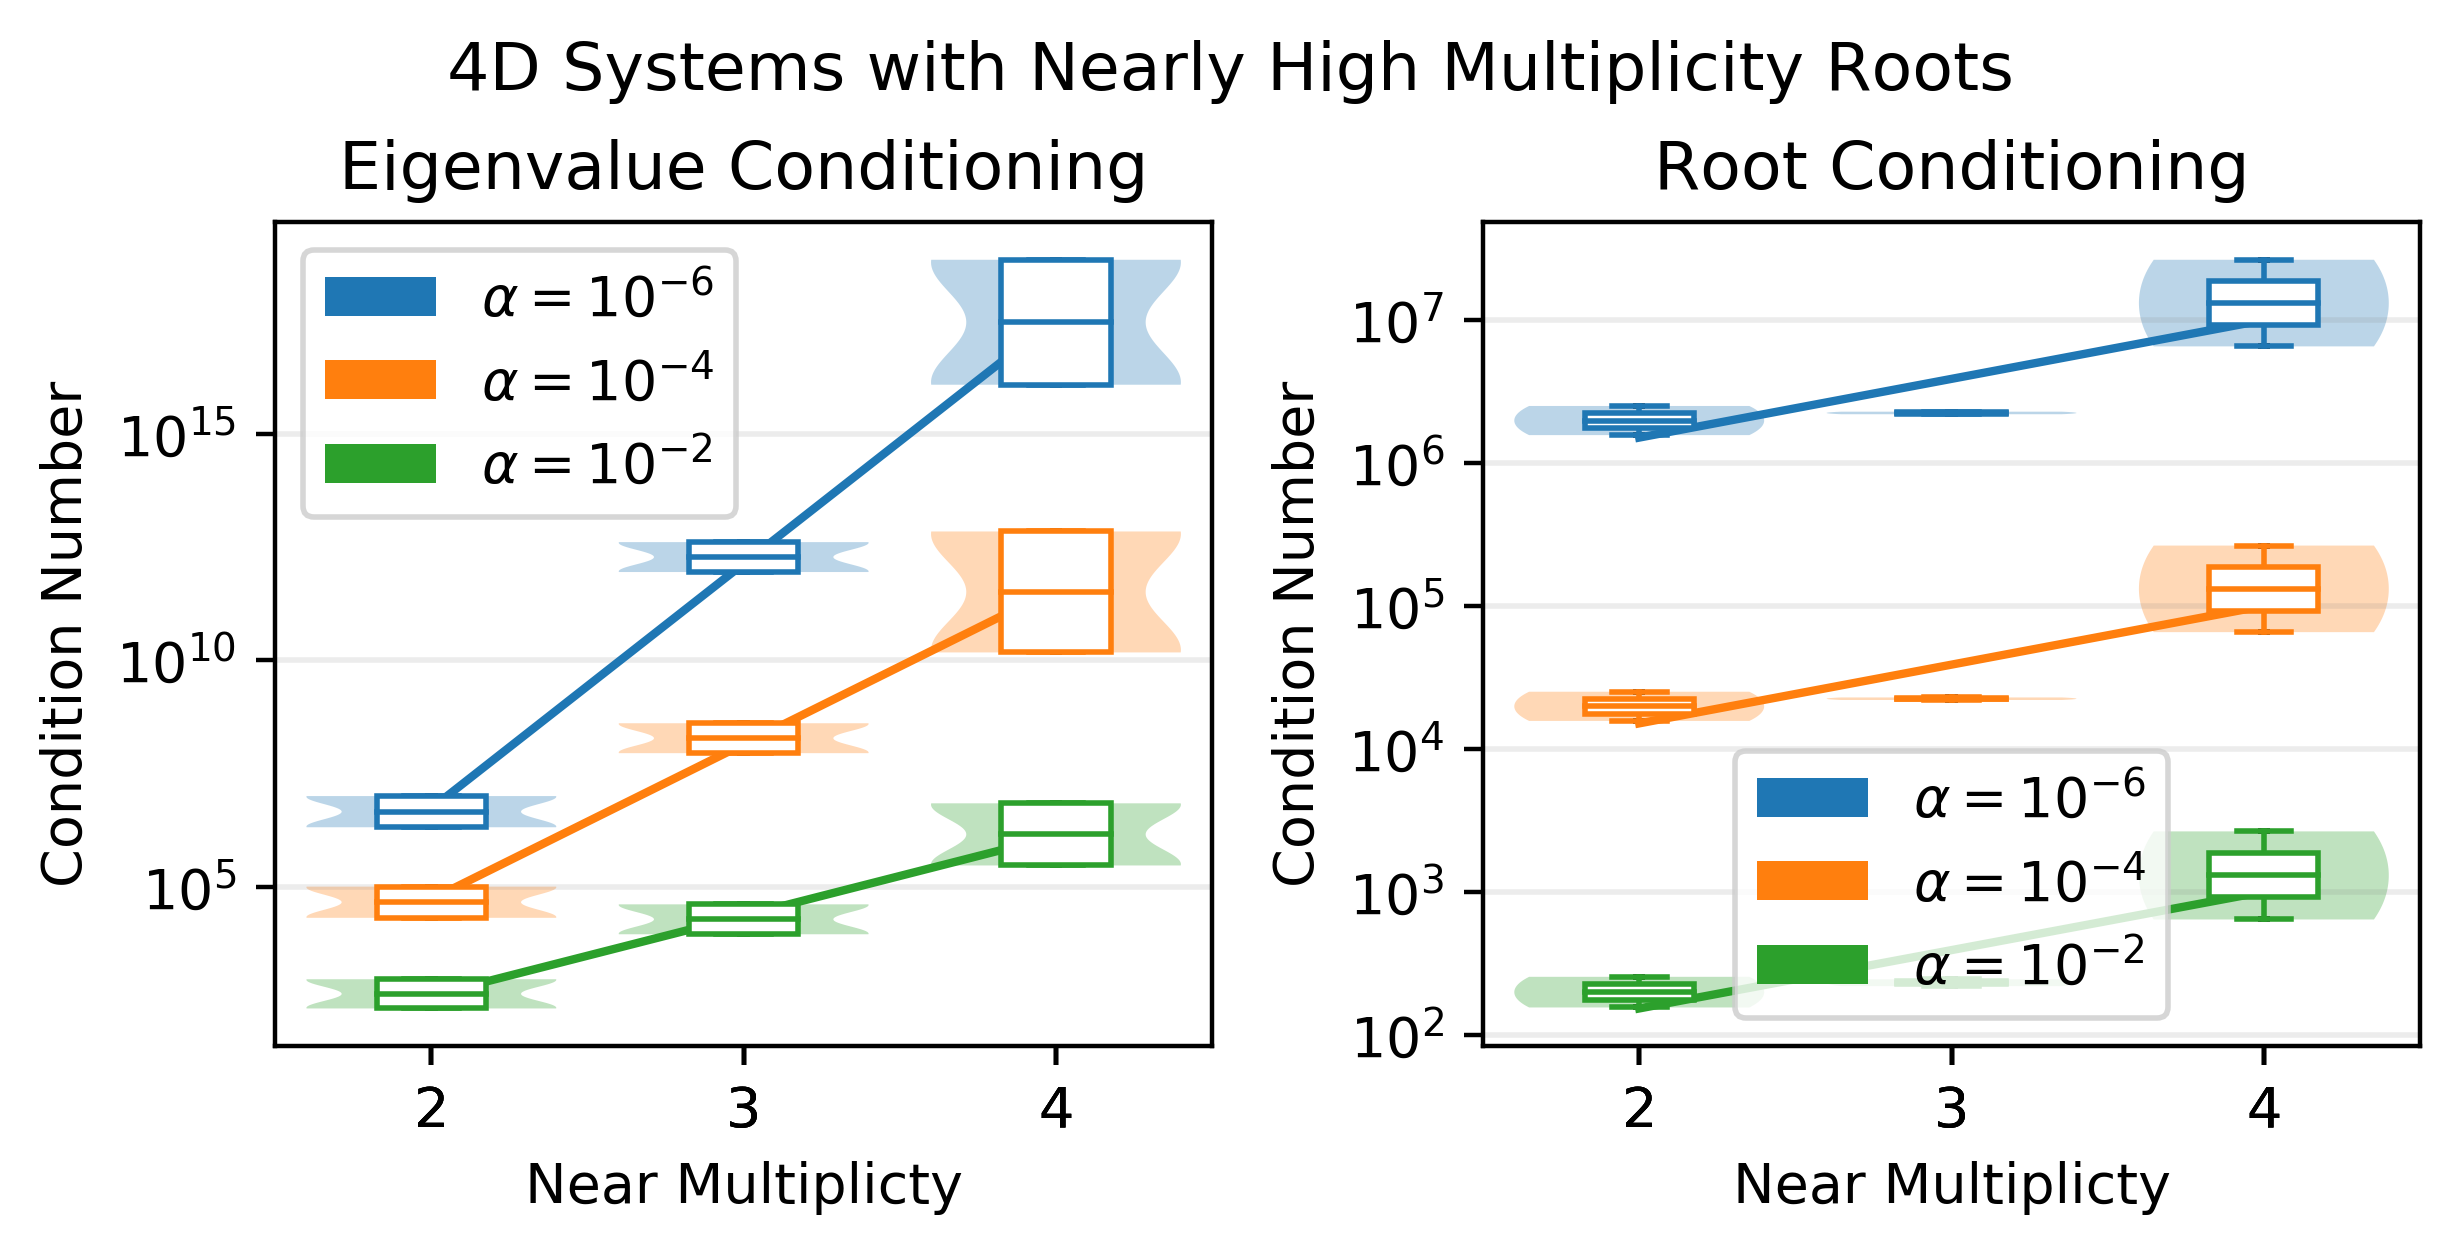

In [25]:
plot([eigenconds[alphas_for_plot_idx],rootconds[alphas_for_plot_idx]],
     [[r'$\alpha=10^{-6}$',
       r'$\alpha=10^{-4}$',
       r'$\alpha=10^{-2}$'],
      [r'$\alpha=10^{-6}$',
       r'$\alpha=10^{-4}$',
       r'$\alpha=10^{-2}$']],
     figsize=(6.25,3.25), filename='mult_eig_v_root_cond', 
     title=['Eigenvalue Conditioning','Root Conditioning',r'4D Systems with Nearly High Multiplicity Roots'],
     yaxislabel='Condition Number',xaxislabel='Near Multiplicty',
     subplots=[1,2])

$\alpha=10^{-6}$
Slope: 4.99364599034793 
Intercept: -9.434327459129676 
Exponential Growth Rate: 98546.5859964413

$\alpha=10^{-4}$
Slope: 3.0154951223902042 
Intercept: -5.485537902720296 
Exponential Growth Rate: 1035.3229653068

$\alpha=10^{-2}$
Slope: 1.3524062688257885 
Intercept: -2.2910176981063257 
Exponential Growth Rate: 21.51159510051139

$\alpha=10^{-6}$
Slope: 4.99364599034793 
Intercept: -9.434327459129676 
Exponential Growth Rate: 98546.5859964413

$\alpha=10^{-4}$
Slope: 3.0154951223902042 
Intercept: -5.485537902720296 
Exponential Growth Rate: 1035.3229653068

$\alpha=10^{-2}$
Slope: 1.3524062688257885 
Intercept: -2.2910176981063257 
Exponential Growth Rate: 21.51159510051139



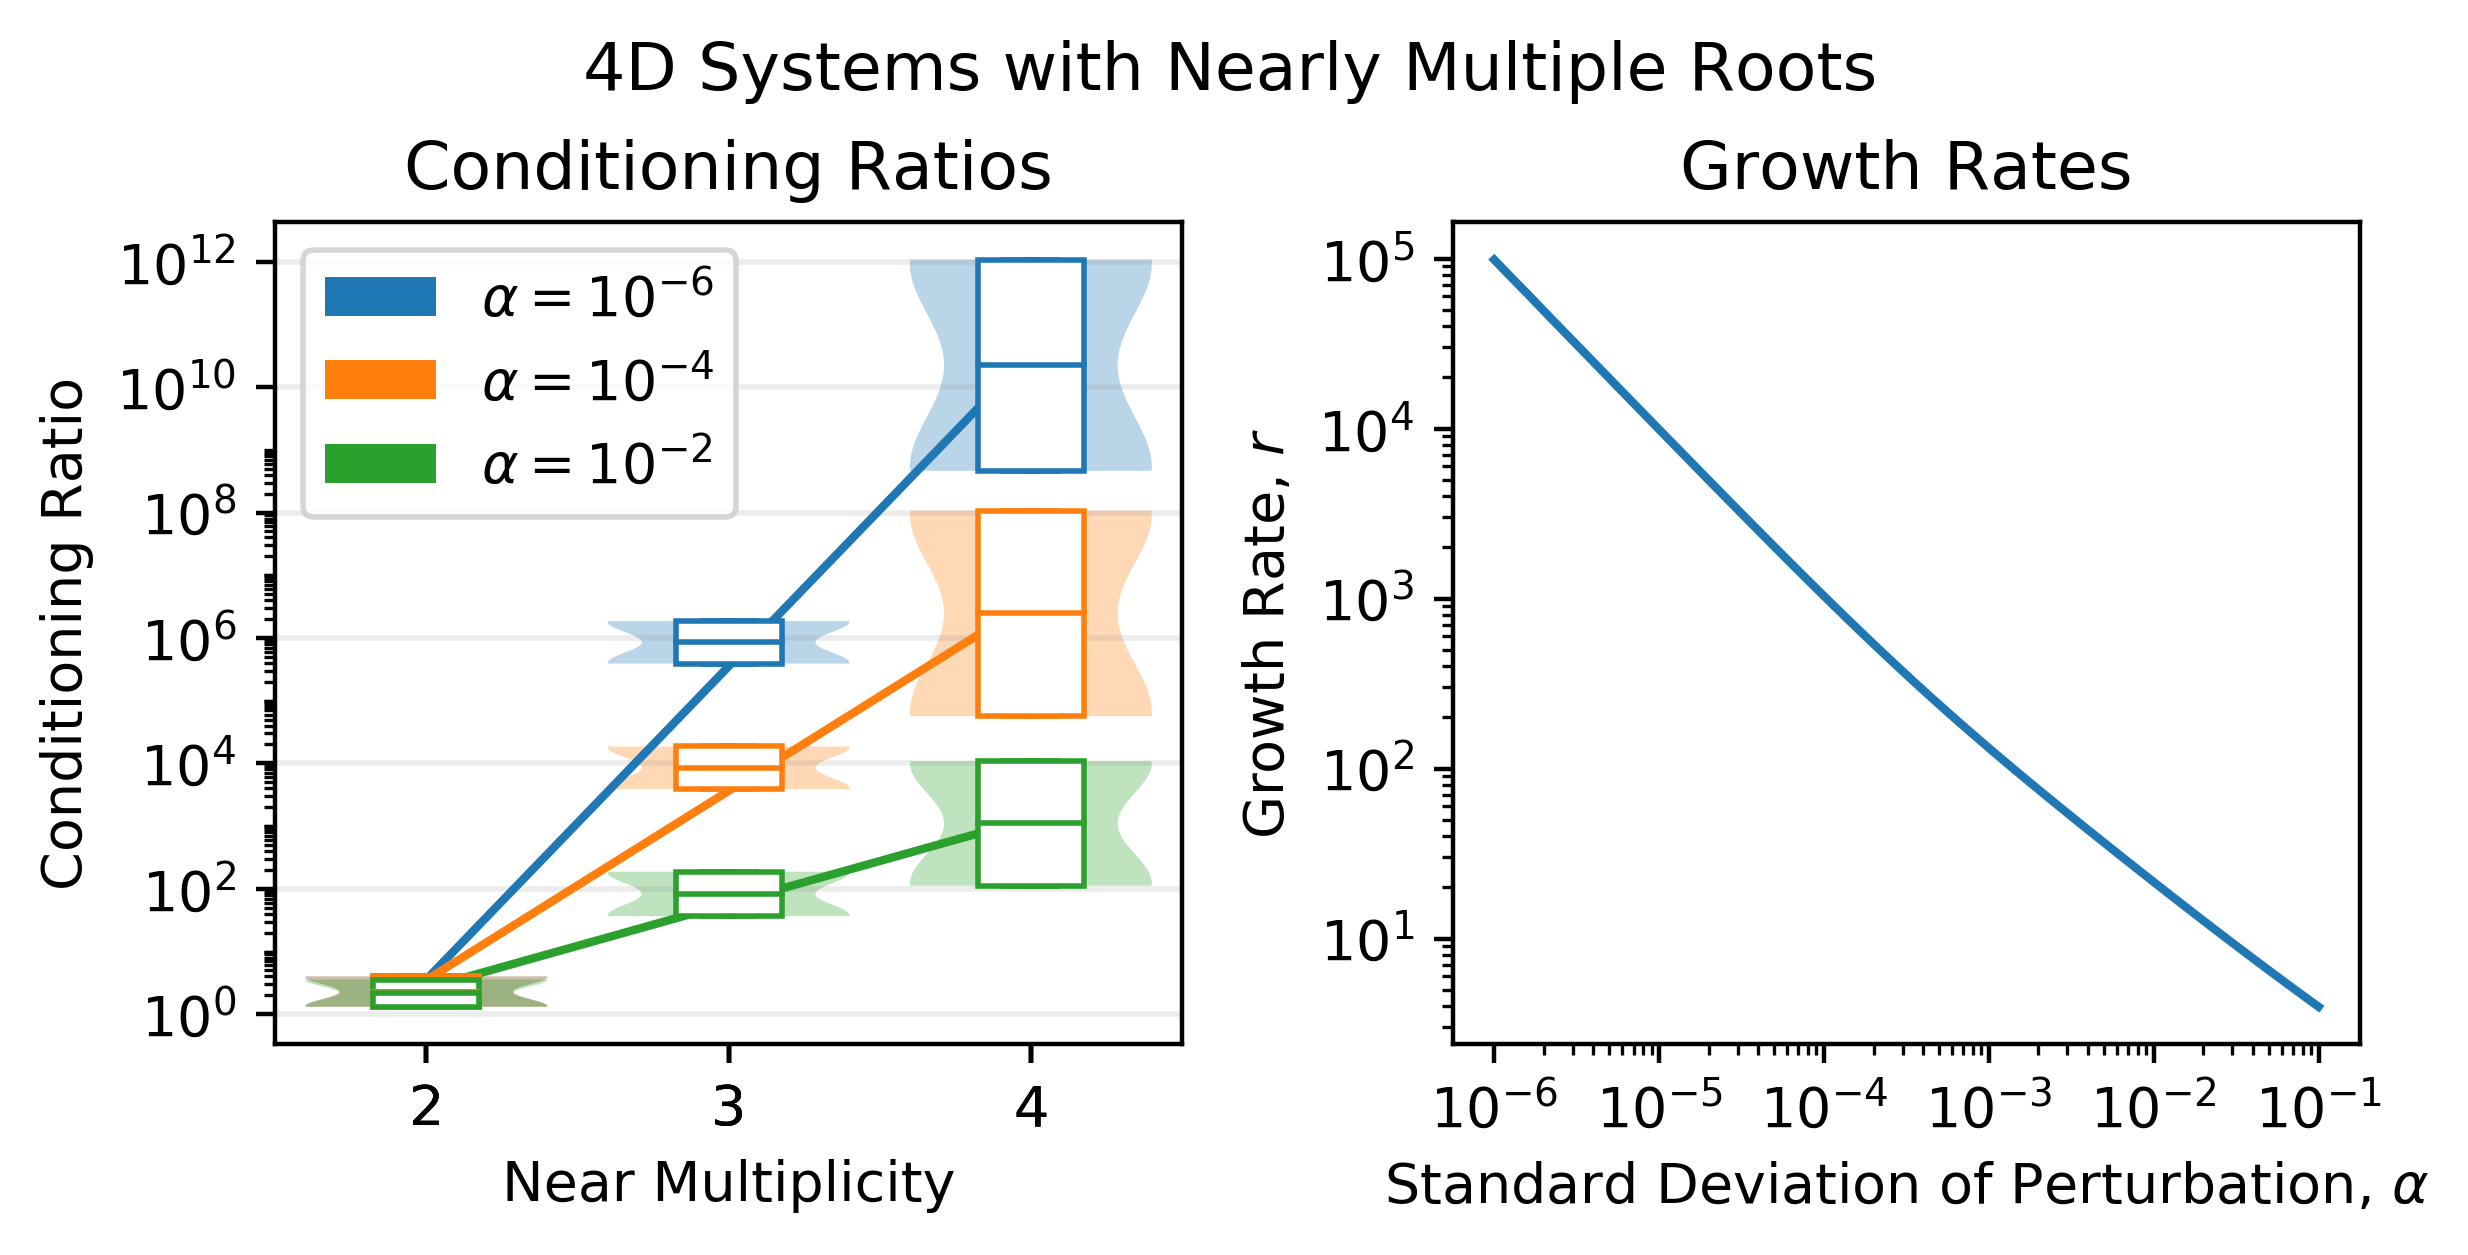

In [26]:
plot([condratios[alphas_for_plot_idx],condratios[alphas_for_plot_idx]],
     [[r'$\alpha=10^{-6}$',
      r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-2}$'],
      [r'$\alpha=10^{-6}$',
      r'$\alpha=10^{-4}$',
      r'$\alpha=10^{-2}$']],
     figsize=(6.25,3.25), filename='dim4_high_multiplicities_with_growth_rates', 
     title=['Conditioning Ratios','Growth Rates',r'4D Systems with Nearly Multiple Roots'],
     subplots=[1,2], 
     xaxislabel='Near Multiplicity',
     _2nd_plot=[alphas[alphasrt],10**np.array(dim4_cratio_slopes_mult[alphasrt])-1],
     min_ylim=0,max_ylim=9,
    _2nd_plot_axis_labels=[r'Standard Deviation of Perturbation, $\alpha$','Growth Rate, $r$'])